In [2]:
import calour as ca 
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from scipy.sparse import csr_matrix
from itertools import combinations, permutations
from calour.training import plot_roc, plot_cm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold,KFold,cross_val_score

/home/liuxuan/.local/lib/python3.8/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/liuxuan/.local/lib/python3.8/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/home/liuxuan/.local/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the bui

In [10]:
pd.set_option('max_colwidth',500)
pd.set_option('max_rows',500)

# functions

In [10]:
def A_pred_B(exp_a, exp_b, field='diagnose', self_validation=True):
    '''training on exp_a to predict exp_b
    params
    ------
    exp_a/exp_b: calour.experiment
    field: str
        column name in sample metadata
    self_validation: True/False
        whether to perform self validation or not. Default is True.
        
    return
    ------
    res_a: pd.DataFrame
        cross validation result for exp_a
    res_b: pd.DataFrame
        the prediction result for exp_b using RF classifer trained on exp_a
    '''
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
    res_a = []
    res_b = []
    if self_validation:
        for i, (train_index, test_index) in enumerate(skf.split(exp_a.data,
                                                                exp_a.sample_metadata[field])):
            x_train = exp_a.data[train_index]
            y_train = exp_a.sample_metadata[field][train_index]
            rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
            rfc.fit(x_train, y_train)

            x_test = exp_a.data[test_index]
            y_test = exp_a.sample_metadata[field][test_index]
            a = pd.DataFrame(rfc.predict_proba(x_test), columns=rfc.classes_)
            a.insert(2, 'Y_TRUE', y_test.tolist())
            a.insert(3, 'CV', i)
            res_a.append(a)

            x_test_b = exp_b.data
            y_test_b = exp_b.sample_metadata[field]
            b = pd.DataFrame(rfc.predict_proba(x_test_b), columns=rfc.classes_)
            b.insert(2, 'Y_TRUE', y_test_b.tolist())
            b.insert(3, 'CV', i)
            res_b.append(b)
        res_a = pd.concat(res_a)
        res_b = pd.concat(res_b)
        return res_a, res_b
    
    else:
        for i, (train_index, test_index) in enumerate(skf.split(exp_a.data,
                                                                exp_a.sample_metadata[field])):
            x_train = exp_a.data[train_index]
            y_train = exp_a.sample_metadata[field][train_index]
            rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
            rfc.fit(x_train, y_train)
            
            x_test_b = exp_b.data
            y_test_b = exp_b.sample_metadata[field]
            b = pd.DataFrame(rfc.predict_proba(x_test_b), columns=rfc.classes_)
            b.insert(2, 'Y_TRUE', y_test_b.tolist())
            b.insert(3, 'CV', i)
            res_b.append(b)
        res_b = pd.concat(res_b)
        return res_b

In [25]:
def cal_roc(result, cv=True, classes=None):
    '''from calour plot_roc'''
    import logging
    logger = logging.getLogger(__name__)
    
    if classes is None:
        classes = np.unique(result['Y_TRUE'].values)
        classes.sort()


    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = roc_curve(y_true.astype(int), df[cls])
                if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                    logger.warning(
                        'The cross validation fold %r is skipped because the true positive rate or '
                        'false positive rate computation failed. This is likely because you '
                        'have either no true positive or no negative samples in this '
                        'cross validation for the class %r' % (grp, cls))
                    continue
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                logger.warning(
                    'The class %r is skipped because the true positive rate or '
                    'false positive rate computation failed. This is likely because you '
                    'have either no true positive or no negative samples for this class' % cls)
            roc_auc = auc(fpr, tpr)
    return mean_auc if cv else roc_auc  

# loading data

In [11]:
tab=ca.read_amplicon('conqur-adjusted-table-rarefied17794.biom',
                     'metadata.txt',
                     normalize=100,min_reads=None)
tab

AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 1059 samples, 4192 features

In [4]:
# tab.sample_metadata.head(2)

,sample_type,project_ID,sequencing_region,diagnose,age,gender,BMI,tumor_site,T_stage,N_stage,...,sequencing_region_merge,host_replicates,treatment_yn,replicate_2,HNSCC,_sample_id,_calour_original_abundance,observed_features,shannon_entropy,faith_pd
sample-id,,,,,,,,,,,,,,,,,,,,,
SRR21105746,Oral_rinse,PRJNA870048,V3-V4,OSCC,63.0,M,NaN,tongue,NaN,NaN,...,V3-V4,NaN,NaN,NaN,NaN,SRR21105746,17794.0,184,3.804584,16.04912
SRR6110936,Saliva,PRJNA412445,V4-V5,OSCC,63.0,F,NaN,NaN,II,0,...,V4-V5,NaN,NaN,NaN,NaN,SRR6110936,17794.0,177,4.731407,18.01963


In [12]:
tab.sample_metadata['diagnose'].value_counts(dropna=False)

OSCC               494
Healthy_control    393
OPMD               172
Name: diagnose, dtype: int64

In [13]:
tab.sample_metadata['project_ID'].value_counts(dropna=False)

PRJNA386665    374
PRJNA870048    181
PRJNA744870    152
PRJEB39064      73
PRJEB37501      73
PRJNA756784     59
OEP000837       44
PRJNA813634     25
PRJNA421234     21
PRJNA751046     18
PRJNA412445     17
PRJNA666891     12
PRJNA700849     10
Name: project_ID, dtype: int64

In [14]:
tab.sample_metadata.pivot_table(values='_sample_id',index='project_ID',columns='diagnose',aggfunc='count')

diagnose,Healthy_control,OPMD,OSCC
project_ID,,,
OEP000837,12.0,NaN,32.0
PRJEB37501,NaN,28.0,45.0
PRJEB39064,25.0,21.0,27.0
PRJNA386665,127.0,123.0,124.0
PRJNA412445,NaN,NaN,17.0
PRJNA421234,7.0,NaN,14.0
PRJNA666891,NaN,NaN,12.0
PRJNA700849,8.0,NaN,2.0
PRJNA744870,76.0,NaN,76.0


In [15]:
projects = ['OEP000837', 'PRJEB39064', 'PRJNA386665', 'PRJNA744870',
            'PRJNA756784', 'PRJNA870048']
tab_f = tab.filter_samples('project_ID', projects).filter_samples(
    'diagnose', ['Healthy_control','OSCC']).filter_abundance(0.00001)
tab_f

AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 739 samples, 2847 features

In [16]:
df = tab_f.sample_metadata.pivot_table(values='_sample_id',index='project_ID',columns='diagnose',aggfunc='count')
df['total_samples'] = df.sum(axis=1)
df

diagnose,Healthy_control,OSCC,total_samples
project_ID,,,
OEP000837,12,32,44
PRJEB39064,25,27,52
PRJNA386665,127,124,251
PRJNA744870,76,76,152
PRJNA756784,39,20,59
PRJNA870048,90,91,181


# classification using differential OTUs with combined FDR <= 0.01

In [5]:
deseq_res = pd.read_csv('differential-analysis-results.csv', index_col=0)
deseq_res.index = [str(i) for i in deseq_res.index]
deseq_res.head(2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low_95,CI_hig_95,CI_low_99,CI_hig_99,taxonomy,ID_taxonomy_name,ID_taxonomy
1000563,1.238753,-0.150033,0.481462,-0.311620,0.755330,NaN,OEP000837,-1.093681,0.793615,-1.390196,1.090130,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,1000563 ; k__Bacteria; p__Bacteroidetes; c__Ba...,1000563 \nk__Bacteria\np__Bacteroidetes\nc__Ba...
1000563,1.363122,-0.005272,0.383247,-0.013756,0.989025,NaN,PRJEB39064,-0.756422,0.745878,-0.992451,0.981907,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,1000563 ; k__Bacteria; p__Bacteroidetes; c__Ba...,1000563 \nk__Bacteria\np__Bacteroidetes\nc__Ba...


In [6]:
deseq_res.shape

(8439, 14)

In [7]:
sig_cutoff = 0.01
diff_otus = deseq_res.query('Study == "Combined" and padj <= %f' % sig_cutoff).index.tolist()
len(diff_otus)

44

## study-to-study prediction

In [44]:
roc_mat_fdr1 = pd.DataFrame(index=projects, columns=projects)
for prj_a, prj_b in permutations(projects, 2):
    exp_a = tab_f.filter_samples('project_ID', prj_a).filter_ids(diff_otus, axis='f')
    exp_b = tab_f.filter_samples('project_ID', prj_b).filter_ids(diff_otus, axis='f')
    a_cv_res, a_pred_b_res = A_pred_B(exp_a, exp_b) 
    roc_mat_fdr1.loc[prj_a, prj_a] = cal_roc(a_cv_res, cv=True, classes=['OSCC'])
    roc_mat_fdr1.loc[prj_a, prj_b] = cal_roc(a_pred_b_res, cv=True, classes=['OSCC'])

In [45]:
# add average row
roc_mat_fdr1.loc['average', :] = roc_mat_fdr1.mean(axis=0)

## leave-one-study-out prediction

In [46]:
for prj in projects:
    exp_a = tab_f.filter_samples('project_ID', prj, negate=True).filter_ids(diff_otus, axis='f')
    exp_b = tab_f.filter_samples('project_ID', prj).filter_ids(diff_otus, axis='f')
    a_pred_b_res = A_pred_B(exp_a, exp_b, self_validation=False) 
    roc_mat_fdr1.loc['leave-one-out', prj] = cal_roc(a_pred_b_res, cv=True, classes=['OSCC'])

In [47]:
# add average column
roc_mat_fdr1.loc[:, 'average'] = roc_mat_fdr1.mean(axis=1)

In [48]:
roc_mat_fdr1.loc['average', 'average'] = np.diag(
    roc_mat_fdr1.loc[projects, projects]).mean() 

In [49]:
roc_mat_fdr1

,OEP000837,PRJEB39064,PRJNA386665,PRJNA744870,PRJNA756784,PRJNA870048,average
OEP000837,0.929933,0.778758,0.635764,0.69702,0.618619,0.776237,0.739388
PRJEB39064,0.879161,0.815318,0.674581,0.726712,0.770768,0.795086,0.776938
PRJNA386665,0.740839,0.709651,0.68665,0.730896,0.705037,0.764664,0.722956
PRJNA744870,0.898343,0.82507,0.668838,0.881353,0.854733,0.89089,0.836538
PRJNA756784,0.853764,0.84162,0.66715,0.79088,0.896616,0.808255,0.809714
PRJNA870048,0.924594,0.84624,0.702832,0.884952,0.871754,0.876117,0.851082
average,0.871106,0.802776,0.672636,0.785302,0.786255,0.818542,0.847664
leave-one-out,0.92551,0.860503,0.697398,0.86459,0.859189,0.91192,0.853185


## heatmap

In [51]:
data=pd.DataFrame(index=roc_mat_fdr1.index,
                  columns=roc_mat_fdr1.columns,
                  data=roc_mat_fdr1.values.astype(float)).round(2)

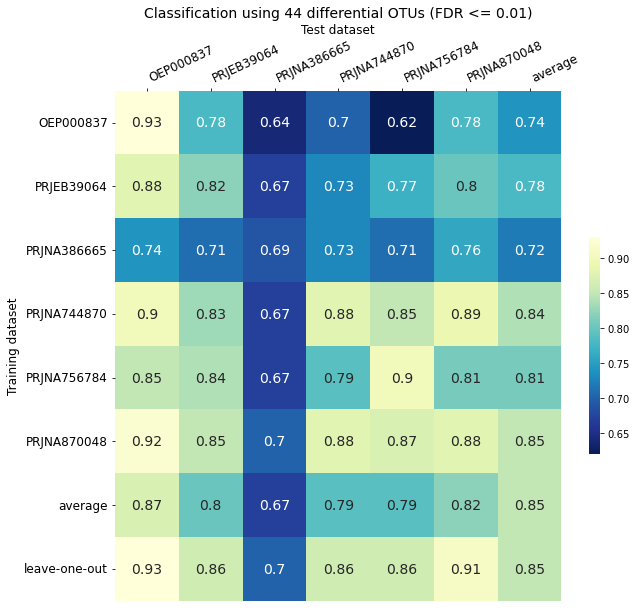

In [54]:
fig,ax=plt.subplots(figsize=(10, 10)) 
sns.heatmap(data, annot=True, fmt='',cmap='YlGnBu_r',cbar=True,square=True,
            cbar_kws={"shrink": 0.4 }, annot_kws={'size':14}, ax=ax)

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
ax.set_title('Classification using %d differential OTUs (FDR <= %.2f)' % (len(diff_otus), sig_cutoff), size=14)
ax.set_ylabel('Training dataset', size=12)
ax.set_xlabel('Test dataset', size=12)
plt.setp(ax.get_xticklabels(), rotation=25, ha='left', size=12)
plt.setp(ax.get_yticklabels(), size=12)
# plt.savefig('figures-and-tables/OSCC-classification-results-using-fdr%.2f-differential-otus.pdf' % sig_cutoff,
#             bbox_inches='tight')